# Аппроксимация коэффициентов диффузии многокомпонентной смеси с помощью нейронных сетей

## Генерация сетки в пространстве параметров
Генерируем сетку в пространстве параметров: $p$, $T$ и количественных долей компонент, и записываем её в файл input.txt

In [1]:
#TODO: Добавить текстовые метки для разных компонент, чтобы было понятно, какая 
# это молекула и на каком уровне
import numpy as np
import time
# Число уровней
comp_names = ['O2', 'N2', 'NO', 'O', 'N']
n_of_levels = {'O2' : 36, 'N2' : 48, 'NO' : 38, 'O' : 1, 'N' : 1}
# print(n_of_levels['O2'])
molar_masses = np.array([32e-3, 28.01e-3, 30.01e-3, 16e-3, 14.01e-3])

# Массив с индексами основных компонент (1-5) для каждой компоненты с учетом уровня (1-124)

comp_inds = np.zeros(124, dtype = np.int)
comp_inds[0:n_of_levels['O2']] = 0 
comp_inds[n_of_levels['O2'] : n_of_levels['O2'] + n_of_levels['N2']] = 1
comp_inds[n_of_levels['O2'] + n_of_levels['N2'] : 
          n_of_levels['O2'] + n_of_levels['N2'] + n_of_levels['NO']] = 2
comp_inds[-1] = 4
comp_inds[-2] = 3
# print(comp_inds)

In [8]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot  as plt
from mpl_toolkits import mplot3d

# Число компонент
ncomp = 5 # Воздух, O2, N2, NO, O, N

# Число узлов по давлению
p_points = 5
# Число узлов по температуре
T_points = 5
# Число узлов по одной концентрации в сетке на симплексе
x_points = 7

# Создаём равномерные сетки по p, T
p_min = 0.5e+5
p_max = 2.0e+5
p_mesh = np.linspace(p_min, p_max, p_points)

T_min = 3.0e+2
T_max = 5e+3
T_mesh = np.linspace(T_min, T_max, T_points)

# Создаём равномерную сетку на симплексе sum(x_i) = 1
ind = 0 # Номер точки в сетке по концентрациям
h = 1 / (x_points - 1)
x_mesh = []
for i1 in range(x_points):
    x1 = i1 * h
    for i2 in range(x_points - i1):
        x2 = i2 * h
        for i3 in range(x_points - i1 - i2):
            x3 = i3 * h
            for i4 in range(x_points - i1 - i2 - i3):
                x4 = i4 * h
                x5 = 1 - x1 - x2 - x3 - x4 
                points = np.array([x1, x2, x3, x4, x5])
                assert (sum(points) - 1) < 1e-13
                if (not np.any(points < 1e-10)):
                    x_mesh.append([x1, x2, x3, x4, x5])
#                     print(x_mesh[-1])
                    ind = ind + 1
x_mesh_size = len(x_mesh)
print('x_mesh size = {0:d}'.format(x_mesh_size))

import itertools
mesh = []
for element in itertools.product(p_mesh, T_mesh, x_mesh):
#     print (type(element[0]))
#     print (type(element[1]))
#     print (type(element[2]))
    list_ = [element[0]] + [element[1]] + element[2]
    mesh.append(np.array(list_))

print(mesh[0])
mesh = np.array(mesh)
print(mesh.shape)

# write mesh to file
path = './'
file = 'input.txt'
np.savetxt(path + file, header = str(mesh.shape[0]) +'\n' + 
           'p T x1 x2 x3 x4 x5', X = mesh, comments='')

x_mesh size = 5
[5.00000000e+04 3.00000000e+02 1.66666667e-01 1.66666667e-01
 1.66666667e-01 1.66666667e-01 3.33333333e-01]
(125, 7)


## Вычисление матриц коэффициентов диффузии с помощью библиотеки Kappa
Вызываем программу, которая с помощью Каппа считает коэффициенты диффузии для каждой точки из файла ```input.txt``` и пишет в файл ```output.txt```

In [17]:
import time
start = time.time()
!Проект1.exe
end = time.time()

print('Time for computing coefficents: {0:5.2e} \n'.format(end - start))
print('Average time for one point: {0:5.2e}'.format((end - start) /mesh.shape[0]))

Diffusion coefficient written to file output.txtTime for computing coefficents: 1.36e+01

Average time for one point: 1.09e-01


In [10]:
125 * 124

15500

In [3]:
import os
output_train_file = 'output_train.txt'
os.replace(r'output.txt', output_train_file)
# os.rename(r'output.txt', output_train_file)

FileNotFoundError: [WinError 2] The system cannot find the file specified: 'output.txt' -> 'output_train.txt'

Читаем коэффициенты диффузии из файла

In [63]:
diff_coeffs = np.loadtxt(output_train_file)
print(diff_coeffs.shape)

(3500, 15376)


In [64]:
print(diff_coeffs[:, 0])

[0.00034096 0.00033343 0.00032603 ... 0.00856736 0.00856806 0.00598124]


In [5]:
N = int(np.sqrt(diff_coeffs.shape[1]))

## Генерация валидационной выборки
Генерируем случайную сетку в том же диапазоне

In [6]:
# Число узлов по давлению
p_points_test = 7
# Число узлов по температуре
T_points_test = 7
# Число узлов по одной концентрации в сетке на симплексе
x_points_test = 20

# Создаём случайные одномерны сетки по p, T
rand_mesh = np.random.rand(p_points_test)
p_mesh_test = p_min + rand_mesh * (p_max - p_min)

rand_mesh = np.random.rand(T_points_test)
T_mesh_test = T_min + rand_mesh * (T_max - T_min)

# Создаём случайную сетку на симплексе sum(x_i) = 1

x_mesh_test_size = 15

count = 0
x_mesh_test = []
while(count < x_mesh_test_size):
    rand_mesh = np.random.rand(ncomp)
    rand_mesh = rand_mesh / np.sum(rand_mesh)
    # ПРоверяем, что нет маленьких концентраций
    if (np.all(rand_mesh > 5e-2)):
        x_mesh_test.append(rand_mesh.tolist())
        count += 1

import itertools
mesh_test = []
for element in itertools.product(p_mesh_test, T_mesh_test, x_mesh_test):
    list_ = [element[0]] + [element[1]] + element[2]
    mesh_test.append(np.array(list_))

print(mesh_test[0])
mesh_test = np.array(mesh_test)
print(mesh_test.shape)

# write mesh to file
path = './'
file = 'input.txt'
np.savetxt(path + file, header = str(mesh_test.shape[0]) +'\n' + 
           'p T x1 x2 x3 x4 x5', X = mesh_test, comments='')

[1.36392971e+05 6.86813295e+02 2.68150521e-01 5.29502293e-02
 1.88296144e-01 3.67862802e-01 1.22740303e-01]
(735, 7)


## Вычисляем значения на тестовой выборке.

In [7]:
start = time.time()
!Проект1.exe
end = time.time()

print('Time for computing coefficents: {0:5.2e}'.format(end - start))
print('Average time for one point: {0:5.2e}'.format((end - start) /mesh_test.shape[0]))

Diffusion coefficient written to file output.txtTime for computing coefficents: 8.45e+01

Average time for one point: 1.15e-01


In [8]:
output_test_file = 'output_test.txt'
os.replace(r'output.txt', output_test_file)

In [9]:
# Читаем из файла
diff_coeffs_test = np.loadtxt(output_test_file)
print(diff_coeffs_test.shape)

(735, 15376)


## Разные сечения многомерной зависимости

Нужно построить различные сечения зависимости для разных элементов матрицы, чтобы понять характер зависимости
1. Для фиксированных концентраций построить colormap или поверхности для зависимости от $(p,T)$
2. То же, но одномерные графики зависимостей от $p$ и $T$
3. Для фиксированных $p, T$ построить одномерные зависимости от концентраций. Например, задать 3 концентрации, для остальных двух получиться $x_1 + x_2 = 1 - (x_3 + x_4 + x_5)$, и построить зависимость от $x_1$
4. Построить зависимость коэффициентов на диагонали от номера возбужденного состояния (для молекул)

### Двумерные сечения при фиксированных концентрациях

In [10]:
# Фиксируем точку по концентрациям (количественным долям)
inds = np.all(mesh[:, 2:7] == x_mesh[3], axis = 1)
print('Fractions = ', x_mesh[3])

# Берём подмножество сетки
mesh_slice = mesh[inds, :]
# Подмножество данных 
data_slice = diff_coeffs[inds, :]

# Размер матрицы
N = int(np.sqrt(diff_coeffs.shape[1]))
print('Size of matrix: {0:d}'.format(N))

Fractions =  [0.125, 0.125, 0.125, 0.5, 0.125]
Size of matrix: 124


Строим двумерные зависимости от $(p,T)$

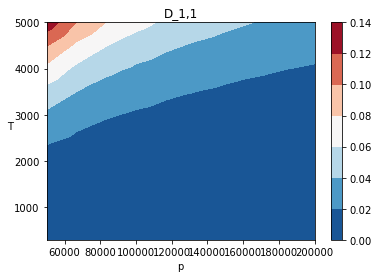

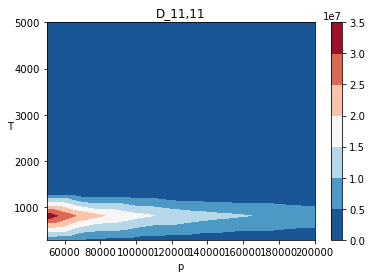

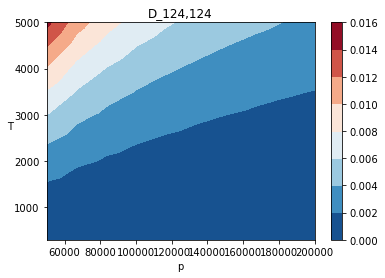

In [11]:
import matplotlib.tri as tri

p = mesh_slice[:, 0] # p
T = mesh_slice[:, 1] # T

# Индексы одного элемента матрицы


index_list = [[0, 0], 
              [10, 10], 
              [123, 123]]
for i, j in index_list:
    # Одномерный индекс для матрицы, "выпрямленной" по стобцам
    index = j * N + i

    d_ij = data_slice[:, index] # d

    triang = tri.Triangulation(p, T)
    interpolator = tri.LinearTriInterpolator(triang, d_ij)
    plt.tricontourf(p, T, d_ij, cmap="RdBu_r")
    plt.xlabel('p')
    plt.ylabel('T', rotation = 0)
    plt.colorbar()
    plt.title('D_'+str(i+1) + ','+  str(j+1))
#     plt.savefig('d_' + str(i+1) + ',' + str(j+1) +'.png', format = 'png', dpi = 600)
    plt.show()


#### Для проверки строим похожие зависимости для тестовой выборки

(15,)
0
[0.26815052 0.05295023 0.18829614 0.3678628  0.1227403 ]
[0.125 0.125 0.125 0.5   0.125]


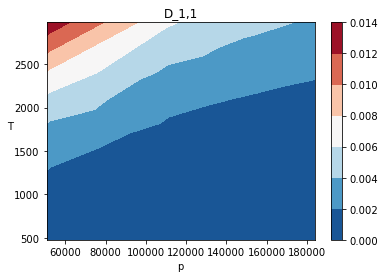

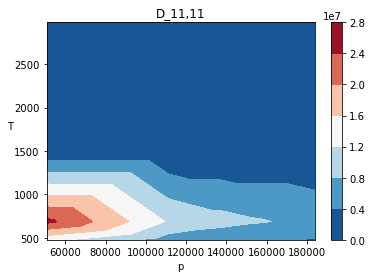

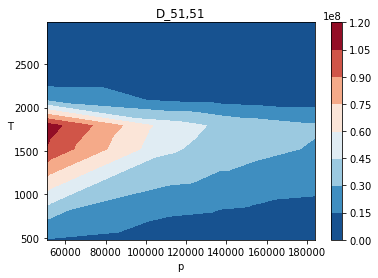

In [12]:
# Находим наиболее близкую точку по концентрациям к x_mesh[3]

x_mesh_test_np = np.array(x_mesh_test)
x_mesh_np = np.array(x_mesh)

delta = x_mesh_test_np - x_mesh_np[3]
delta = np.linalg.norm(delta, axis = 1)
print(delta.shape)
x_ind = np.argmin(delta)
print(x_ind)
print(x_mesh_test_np[x_ind])
print(x_mesh_np[3])

inds = np.all(mesh_test[:, 2:7] == x_mesh_test_np[x_ind], axis = 1)

# Берём подмножество сетки
mesh_test_slice = mesh_test[inds, :]

p = mesh_test_slice[:, 0] # p
T = mesh_test_slice[:, 1] # T
# Подмножество данных 
data_slice_test = diff_coeffs_test[inds, :]

index_list = [[0, 0], 
              [10, 10], 
              [50, 50]]
for i, j in index_list:
    # Одномерный индекс для матрицы, "выпрямленной" по стобцам
    index = j * N + i

    d_ij = data_slice_test[:, index] # d

    triang = tri.Triangulation(p, T)
    interpolator = tri.LinearTriInterpolator(triang, d_ij)
    plt.tricontourf(p, T, d_ij, cmap="RdBu_r")
    plt.xlabel('p')
    plt.ylabel('T', rotation = 0)
    plt.colorbar()
    plt.title('D_'+str(i+1) + ','+  str(j+1))
#     plt.savefig('d_' + str(i+1) + ',' + str(j+1) +'.png', format = 'png', dpi = 600)
    plt.show()

### Одномерные зависимости от $T$ при фиксированных концентрациях и $p$

Fractions =  [0.125, 0.125, 0.125, 0.5, 0.125]
p = 1.33e+05
inds size =  10


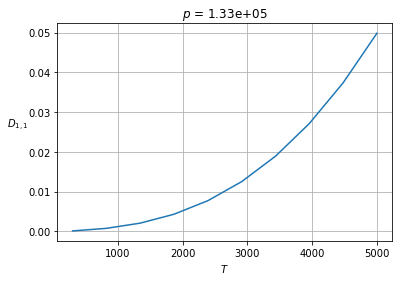

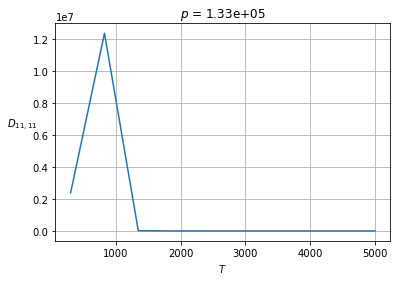

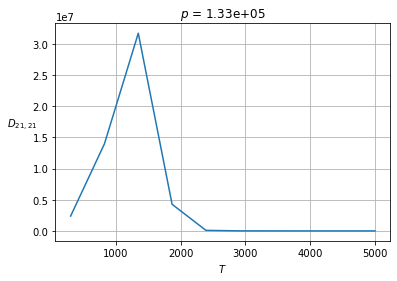

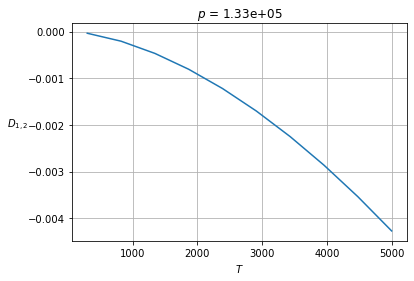

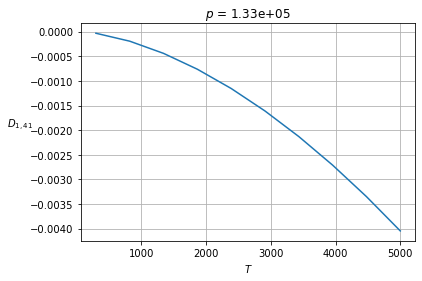

In [13]:
# Фиксируем точку по концентрациям (количественным долям)
# и по p
p_value = p_mesh[p_points//2]
inds = np.all(mesh[:, 2:] == x_mesh[3], axis = 1) * (mesh[:, 0] == p_value)
print('Fractions = ', x_mesh[3])
print('p = {0:5.2e}'.format(p_value))
print('inds size = ', np.sum(inds))

# Берём подмножество сетки
mesh_slice = mesh[inds, :]
# Подмножество данных 
data_slice2 = diff_coeffs[inds, :]

temp_values = mesh_slice[:, 1]

index_list = [[0, 0], 
              [10, 10], 
              [20, 20],
             [0, 1], 
             [0, 40]]
for i, j in index_list:
        # Одномерный индекс для матрицы, "выпрямленной" по стобцам
    index = j * N + i
    d_ij = data_slice2[:, index] # d
    plt.plot(temp_values, d_ij)
    plt.xlabel('$T$')
    plt.ylabel('$D_{' + str(i+1) +',' +  str(j+1) + '}$', rotation = 0, labelpad = 10)
    plt.grid(True)
    plt.title('$p$ = {0:5.2e}'.format(p_value))
    plt.show()

## Одномерные зависимости от $p$

Fractions =  [0.125, 0.125, 0.125, 0.5, 0.125]
T = 2.91e+03
inds size =  10


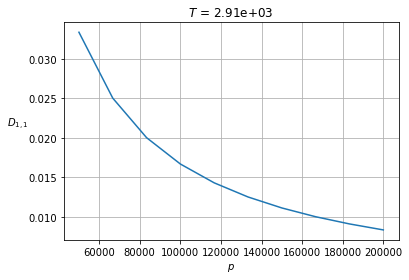

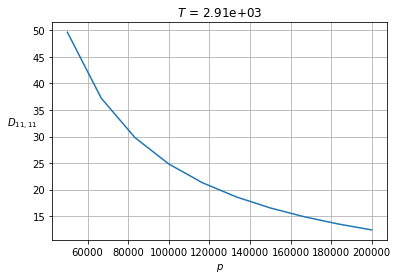

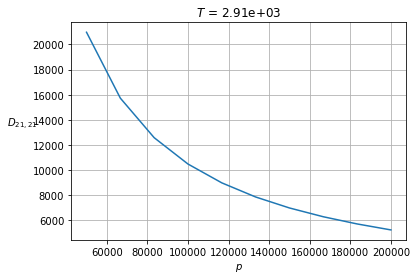

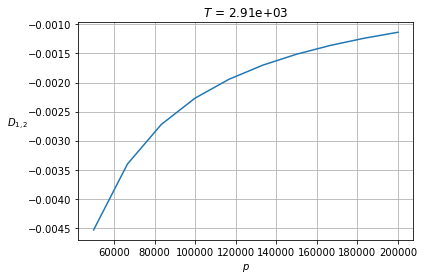

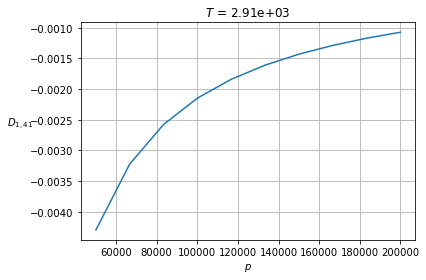

In [15]:
# Фиксируем точку по концентрациям (количественным долям)
# и по T
T_value = T_mesh[T_points//2]
inds = np.all(mesh[:, 2:] == x_mesh[3], axis = 1) * (mesh[:, 1] == T_value)
print('Fractions = ', x_mesh[3])
print('T = {0:5.2e}'.format(T_value))
print('inds size = ', np.sum(inds))

# Берём подмножество сетки
mesh_slice = mesh[inds, :]
# Подмножество данных 
data_slice_const_T = diff_coeffs[inds, :]

p_values = mesh_slice[:, 0]

index_list = [[0, 0], 
              [10, 10], 
              [20, 20],
             [0, 1], 
             [0, 40]]
for i, j in index_list:
        # Одномерный индекс для матрицы, "выпрямленной" по стобцам
    index = j * N + i
    d_ij = data_slice_const_T[:, index] # d
    plt.plot(p_values, d_ij)
    plt.xlabel('$p$')
    plt.ylabel('$D_{' + str(i+1) +',' +  str(j+1) + '}$', rotation = 0, labelpad = 10)
    plt.grid(True)
    plt.title('$T$ = {0:5.2e}'.format(T_value))
    plt.show()

### Зависимость от концентраций при фиксированных p,T

inds size =  10


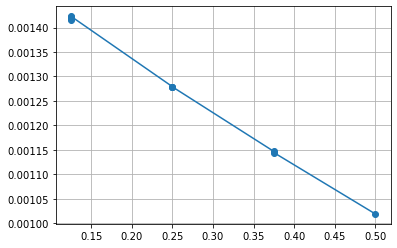

In [16]:
# Фиксируем p и T, и все концентрации кроме 2-х первых
# Все остальные концентрации берём равными шагу сетки "h"

inds = np.all(mesh[:, 5:] == h, axis = 1) * (mesh[:, 1] == T_value) *\
    (mesh[:, 0] == p_value)

print('inds size = ', np.sum(inds))

mesh_slice_fixed_fractions = mesh[inds, :]
data_slice_fixed_fractions = diff_coeffs[inds, :]

# концентрация 1-й компоненты
n1 = mesh_slice_fixed_fractions[:, 2]
#
index_list = [[0, 0]]
#               [10, 10], 
#               [20, 20],
#              [0, 1], 
#              [0, 40]]
for i, j in index_list:
        # Одномерный индекс для матрицы, "выпрямленной" по стобцам
    index = j * N + i
    d_ij = data_slice_fixed_fractions[:, index] # d
    plt.plot(n1, d_ij * n1, 'o-')
    plt.grid(True)
    plt.show()

### Зависимость диагональных коэффициентов от индекса

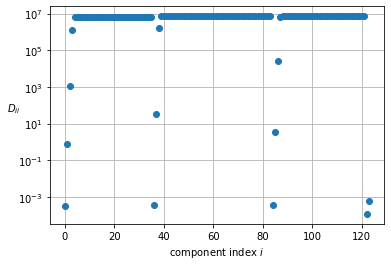

In [17]:
# print(diff_coeffs[0, :100])


diff_mat = np.reshape(diff_coeffs[0, :], (124, 124), order = 'F')
diag = np.diag(diff_mat)
# plt.semilogy(diff_mat[:,0])
# plt.semilogy(diff_mat[:,1])
# plt.semilogy(diff_mat[:,2])
# plt.semilogy(diff_mat[:,3])
plt.semilogy(diag[:124], 'o')
plt.xlabel('component index $i$')
plt.ylabel('$D_{ii}$', rotation = 0)
plt.grid(True)
# plt.savefig('Diagonal_vs_index.png', dpi = 600)
plt.show()

# plt.matshow(diff_mat[:, :])
# print(np.linalg.norm(diff_mat - diff_mat.T))
# print(diff_mat[:, :])
# plt.colorbar()
# plt.savefig('diff_matrix.png', format = 'png', dpi = 600)

Задача: по $p$ $T$ и количественным долям нужно вычислить массовые концентрации

Формула: 
$$
\rho_i = \frac{\rho x_i M_i}{M}
$$
$\rho$ находится из уравнения состояния идеального газа для смеси 
$$
p = \frac{\rho R_u T}{M} \Rightarrow \rho = \frac{p M}{R_u T}
$$

In [18]:
# Сетка в переменных (T, rho_1, ..., rho_5)
mesh_rhoi = np.zeros((mesh.shape[0], 6))

def compute_molar_mass(xs):
    """Compute molar mass of mixture
    xs - molar fractions of components
    """
    return xs @ molar_masses

# Универсальная газовая постоянная
R_u = 8.31446261815324

def from_frac_to_rhoi(in_mesh):
    """Преобразуем (p, T, x_1, ..., x_n) в (T, rho_1, ..., rho_n)
    """
    out_mesh = np.zeros((in_mesh.shape[0], 6))
    molar_mass = compute_molar_mass(in_mesh[:, 2:7])
    
    # Из уравнения состояния идеального газа
    # rho = p * M / (R_u * T)
    rho = in_mesh[:, 0] * molar_mass / (R_u * in_mesh[:, 1])
    
    for i in range(in_mesh.shape[0]):
        out_mesh[i, 0] = in_mesh[i, 1] # T
        out_mesh[i, 1:6] = rho[i] * in_mesh[i, 2:7] * molar_masses / molar_mass[i]
    
    return out_mesh
# molar
mesh_rhoi = from_frac_to_rhoi(mesh)
    
# Добавляем эти данные к сетке
mesh_extended = np.concatenate((mesh, mesh_rhoi[:, 1:]), axis = 1)

# То же самое для тестовой выборки
mesh_test_rhoi = from_frac_to_rhoi(mesh_test)
mesh_test_extended = np.concatenate((mesh_test, mesh_test_rhoi[:, 1:]), axis = 1)

In [19]:
print(mesh_test[0])
print(mesh_test_extended.shape)

[1.36392971e+05 6.86813295e+02 2.68150521e-01 5.29502293e-02
 1.88296144e-01 3.67862802e-01 1.22740303e-01]
(735, 12)


## Нормировка данных

Нужно отнормировать все параметры, чтобы они менялись в одинаковых пределах, желательно в диапазоне $[0,1]$ или $[-1,1]$, так удобнее работать с нейросетями.

Кажется, что самый простой способ просто вычислить на обучающей выборке максимум и минимум для каждого коэффициента, и потом сделать линейное преобразование:

In [20]:
max_value = np.max(diff_coeffs, axis = 0)
min_value = np.min(diff_coeffs, axis = 0)

def normalize_diff_coeffs(diff_coeffs_):
    diff_coeffs_scaled_ = 2 * (diff_coeffs_ - min_value) / (max_value - min_value) - 1
    
    return diff_coeffs_scaled_

diff_coeffs_scaled = normalize_diff_coeffs(diff_coeffs)
diff_coeffs_test_scaled = normalize_diff_coeffs(diff_coeffs_test)

# Нормируем входные параметры (p и T)

rhoi_max = np.max(mesh_rhoi[:, 1:6], axis = 0)
rhoi_min  = np.min(mesh_rhoi[:, 1:6], axis = 0)

def normalize_frac_mesh(mesh):
    mesh_scaled = np.copy(mesh)
    mesh_scaled[:, 0] = (mesh[:, 0] - p_min)/(p_max - p_min)
    mesh_scaled[:, 1] = (mesh[:, 1] - T_min)/(T_max - T_min)
    return mesh_scaled

def normalize_conc_mesh(mesh):
    mesh_scaled = np.copy(mesh)
    mesh_scaled[:, 0] = (mesh[:, 0] - T_min)/(T_max - T_min)
    mesh_scaled[:, 1:6] = 2 * (mesh[:, 1:6] - rhoi_min) / (rhoi_max - rhoi_min) - 1
    return mesh_scaled

mesh_scaled = normalize_frac_mesh(mesh)
mesh_rhoi_scaled = normalize_conc_mesh(mesh_rhoi)

mesh_test_scaled = normalize_frac_mesh(mesh_test)
mesh_test_rhoi_scaled = normalize_conc_mesh(mesh_test_rhoi)

In [21]:
print(mesh_test_rhoi_scaled[0, :])

[ 0.0823007  -0.68681649 -0.94419902 -0.78232343 -0.56755922 -0.86072913]


## Нейронная сеть для аппроксимации зависимости

**! Важный вопрос: как выбрать входные переменные?**.

Т.к. количественные доли зависимы ($\sum n_i = 1$), то возможно лучше перейти к массовой концентрации компонент $\rho_i$ (отношение массы компонента к объёму смеси). Тогда сумма всех концентраций равна плотности $\sum \rho_i = \rho$

In [22]:
mesh_rhoi[0, :]

array([3.00000000e+02, 8.01815700e-02, 7.01839305e-02, 7.51952786e-02,
       4.00907850e-02, 1.40417975e-01])

### Архитектура сети

In [44]:
import torch
from torch import nn

class MyNet1(nn.Module):
    def __init__(self, in_size = 6, 
             out_size = 124, sizes_of_layers = [32, 32, 32], 
                 dropout = 0.5):
        super().__init__()
        self.in_size = in_size
        self.out_size = out_size
        self.sizes_of_layers = [in_size] + sizes_of_layers + [out_size]
        
        self.module_list = nn.ModuleList()
        
        for i in range(len(self.sizes_of_layers) - 2):  
            self.module_list.append(
                nn.Sequential(
                    nn.Linear(self.sizes_of_layers[i], self.sizes_of_layers[i+1]), 
                    nn.Sigmoid(),
                    nn.Dropout(p = dropout)
                )
            )
        # Добавляем последний слой без сигмоиды
        self.module_list.append(
            nn.Sequential(
                nn.Linear(self.sizes_of_layers[-2], self.sizes_of_layers[-1])
            )   
        )
    def forward(self, x):
        for layer in self.module_list:
            x = layer(x)
        return x

### Функция для обучения сети с выводом отладочной информации

In [24]:
def my_loss_fun1(y1, y2):
    loss = torch.norm(y1 - y2, dim = 1)**2 / y1.shape[1]
    
    return torch.mean(loss)

# Вычисляет среднюю по выборке ошибку во 2-й норме
def mean_error(y_true, y_pred):
    error = torch.norm(y_true - y_pred, dim = 1) /\
        y_true.shape[1]**0.5 
    error = torch.mean(error)
    return error

def my_train(model, num_epochs, x_train, y_train, x_test,
             y_test, opt, print_freq = 100):
#     loss_fun = my_loss_fun1 
    loss_fun = nn.MSELoss()
    train_loss_list = np.zeros(num_epochs)
    test_loss_list  = np.zeros(num_epochs)
    train_err = np.zeros(num_epochs)
    test_err = np.zeros(num_epochs)
    
    data_size = 0
    for x in x_train:
        data_size += len(x)
    
    for epoch in range(num_epochs):
        model.train()
        avg_loss = 0
        avg_error = 0
        for x, y in zip(x_train, y_train):
            opt.zero_grad()
            y_pred = model(x)
            loss = loss_fun(y_pred, y)
            loss.backward()
            opt.step()
            avg_loss += loss
            avg_error += mean_error(y, y_pred)
        avg_loss = avg_loss / len(x_train)
        avg_error = avg_error / len(x_train)
        train_err[epoch] = avg_error
        train_loss_list[epoch] = avg_loss
        
        # Вычисляем ошибку на обучающей выборке
        model.eval()
#         y_pred = model(x_train)
#         loss = loss_fun(y_pred, y_train)
#         train_loss_list[epoch] = loss
        
        # Вычисляем ошибку на тестовой выборке
        y_pred = model(x_test)
        loss = loss_fun(y_pred, y_test)
        test_err[epoch] = mean_error(y_test, y_pred)
        test_loss_list[epoch] = loss
        model.train()
        if (epoch % print_freq == 0):
            print('epoch: {2:d}, train loss: {0:5.2e}, test loss: {1:5.2e},'\
                  '\n train err: {3:5.2e}, test err: {4:5.2e}'.format(
                train_loss_list[epoch],
                test_loss_list[epoch],
                epoch,
                train_err[epoch],
                test_err[epoch]
            ))
    return train_loss_list, test_loss_list, train_err, test_err

#### Составляем обучающую и тестовую выборки

In [25]:
x_train_np = np.copy(mesh_rhoi)
x_test_np  = np.copy(mesh_test_rhoi)


# Берем диагональ матрицы коэффициентов
# умножаем на количественную долю
y_train_np = np.zeros((mesh.shape[0], 124))
for i in range(mesh.shape[0]):
    for j in range(y_train_np.shape[1]):
        y_train_np[i, j] = np.diag(
            np.reshape(diff_coeffs[i, :], (124, 124), order = 'F')
        )[j] * mesh[i, comp_inds[j] + 2] 

y_test_np = np.zeros((mesh_test.shape[0], 124))
for i in range(mesh_test.shape[0]):
    for j in range(y_train_np.shape[1]):
        y_test_np[i, j] = np.diag(
            np.reshape(diff_coeffs_test[i, :], (124, 124), order = 'F')
        )[j] * mesh_test[i, comp_inds[j] + 2] 
    
# Нормируем выборки

x_max_vals = np.max(x_train_np, axis = 0)
x_min_vals = np.min(x_train_np, axis = 0)

y_max_vals = np.max(y_train_np, axis = 0)
y_min_vals = np.min(y_train_np, axis = 0)

def normalize_x(x):
    x_ = np.copy(x)
    x_ = 2 * (x - x_min_vals) / (x_max_vals - x_min_vals) - 1
    return x_

def normalize_y(y):
    y_ = np.copy(y)
    y_ = 2 * (y - y_min_vals) / (y_max_vals - y_min_vals) - 1
    return y_

x_train_np = normalize_x(x_train_np)
x_test_np  = normalize_x(x_test_np)


y_train_np = normalize_y(y_train_np)
y_test_np  = normalize_y(y_test_np)

    
x_train = torch.from_numpy(x_train_np)
x_test  = torch.from_numpy(x_test_np)
y_train = torch.from_numpy(y_train_np)
y_test  = torch.from_numpy(y_test_np)

In [26]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

torch.Size([3500, 6]) torch.Size([3500, 124])
torch.Size([735, 6]) torch.Size([735, 124])


In [27]:
print(x_train[255, :])

tensor([ 0.5556, -0.9980, -0.9885, -0.9980, -0.9980, -0.9790],
       dtype=torch.float64)


Concentrations =  [-0.68681649 -0.94419902 -0.78232343 -0.56755922 -0.86072913]
49


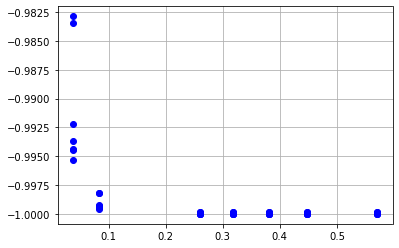

In [28]:
# Фиксируем точку по концентрациям (количественным долям)
inds = np.all(mesh_test[:, 2:7] == mesh_test[0, 2:7], axis = 1)
print('Concentrations = ', x_test_np[0, 1:6])
print(np.sum(inds))

# Берём подмножество сетки
x_slice = mesh_test_scaled[inds, :]
# Подмножество данных 
y_slice = y_test_np[inds, 2]

import matplotlib.tri as tri

T_slice = x_slice[:, 1] # T

plt.plot(T_slice, y_slice, 'bo')
plt.grid(True)

#### Разбиваем на батчи обучающую выборку

In [35]:
def split_into_batches(X_, Y_, batch_size):
    X_split = []
    Y_split = []
    
    X = torch.clone(X_)
    Y = torch.clone(Y_)
    # Перемешиваем выборку
#     perm = torch.randperm(X.shape[0])
    
#     X = X[perm]
#     Y = Y[perm]
    
    for i in range(X.shape[0] // batch_size):
        X_split.append(X[i * batch_size : (i+1) * batch_size])
        Y_split.append(Y[i * batch_size : (i+1) * batch_size])
    
    if(X.shape[0] > (i+1) * batch_size):
        X_split.append(X[(i+1) * batch_size :])
        Y_split.append(Y[(i+1) * batch_size :])
        
    return X_split, Y_split

x_split, y_split = split_into_batches(x_train, y_train, 3500)
print(len(x_split))

1


In [36]:
my_model = MyNet1(
    out_size = 124, sizes_of_layers=[64, 64, 64], dropout = 0.02
).double()

In [53]:
optimizer = torch.optim.AdamW(my_model.parameters(), lr = 5e-2, weight_decay=1e-2)

In [59]:
train_loss, test_loss, train_err, test_err = my_train(
    my_model, num_epochs=1001, x_train = x_split, y_train = y_split,
    x_test = x_test, y_test = y_test, opt = optimizer, print_freq = 50 
)

epoch: 0, train loss: 1.00e-02, test loss: 3.65e-02,
 train err: 7.95e-02, test err: 1.49e-01
epoch: 50, train loss: 9.64e-03, test loss: 3.60e-02,
 train err: 7.83e-02, test err: 1.49e-01
epoch: 100, train loss: 9.92e-03, test loss: 3.54e-02,
 train err: 8.02e-02, test err: 1.49e-01
epoch: 150, train loss: 9.15e-03, test loss: 3.74e-02,
 train err: 7.86e-02, test err: 1.51e-01
epoch: 200, train loss: 9.28e-03, test loss: 3.42e-02,
 train err: 7.65e-02, test err: 1.43e-01
epoch: 250, train loss: 8.63e-03, test loss: 3.65e-02,
 train err: 7.56e-02, test err: 1.51e-01
epoch: 300, train loss: 8.53e-03, test loss: 3.67e-02,
 train err: 7.39e-02, test err: 1.50e-01
epoch: 350, train loss: 8.71e-03, test loss: 3.67e-02,
 train err: 7.59e-02, test err: 1.49e-01
epoch: 400, train loss: 8.02e-03, test loss: 3.31e-02,
 train err: 7.10e-02, test err: 1.38e-01
epoch: 450, train loss: 7.85e-03, test loss: 3.51e-02,
 train err: 7.19e-02, test err: 1.45e-01
epoch: 500, train loss: 7.60e-03, test loss

In [60]:
# torch.save(my_model, 'my_model')
torch.save(my_model.state_dict(), 'my_model_dict')

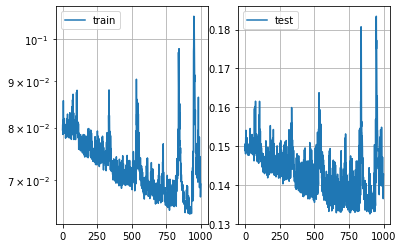

In [61]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.semilogy(train_err, label = 'train')
ax1.legend()
ax1.grid(True)
ax2.plot(test_err, label = 'test')
ax2.legend()
ax2.grid(True)

#### Проверка качества модели

Для проверки качества построим двумерные распределения при фиксированных концентрациях

Fractions: [0.12033323 0.34178438 0.16610412 0.24395437 0.1278239 ]


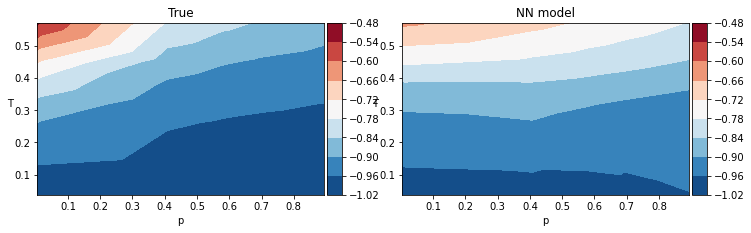

Text(0.5, 1.0, 'Error')

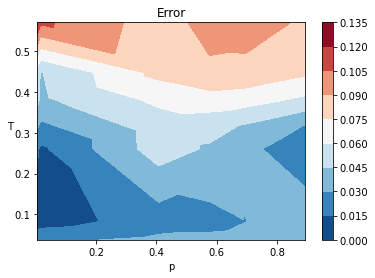

In [62]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

my_model.eval()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize  = (12, 5))
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes('right', size='5%', pad=0.05)

divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes('right', size='5%', pad=0.05)

index = 1
inds = np.all(mesh_test[:, 2:7] == mesh_test[index, 2:7], axis = 1)

print('Fractions:', mesh_test[index, 2:7])
# Берём подмножество сетки
mesh_test_slice = mesh_test_scaled[inds, :]

diag_ind = 0

p = mesh_test_slice[:, 0] # p
T = mesh_test_slice[:, 1] # T
# Подмножество данных 
d_ij = y_test_np[inds, diag_ind] # d

triang = tri.Triangulation(p, T)
# interpolator = tri.LinearTriInterpolator(triang, d_ij)

tri1 = ax1.tricontourf(triang, d_ij, cmap="RdBu_r")
fig.colorbar(tri1, cax = cax1)
ax1.set_title('True')
ax1.set_xlabel('p')
ax1.set_ylabel('T', rotation = 0)
ax1.set_aspect('equal')


# Теперь пересчитываем эти точки в переменных T, rho_i

mesh_conc = from_frac_to_rhoi(mesh_test[inds, :])

# Нормируем 

mesh_conc_norm = normalize_conc_mesh(mesh_conc)

y_pred = my_model(x_test[inds, :]).detach().numpy()

tri2 = ax2.tricontourf(triang, y_pred[:, diag_ind] , cmap="RdBu_r", levels = tri1.levels)
ax2.set_xlabel('p')
ax2.set_ylabel('T', rotation = 0)
ax2.set_aspect('equal')
ax2.set_title('NN model')
fig.colorbar(tri1, cax = cax2)

# plt.savefig('d_11_compare_test.png', dpi = 600, bbox_inches = 'tight')

plt.show()

plt.tricontourf(triang, np.abs(y_pred[:, diag_ind] - d_ij) , cmap="RdBu_r")
plt.xlabel('p')
plt.ylabel('T', rotation = 0)
plt.colorbar()
plt.title('Error')
# plt.savefig('d_11_error.png', dpi = 600, bbox_inches = 'tight')

In [84]:
tri1.levels

array([-1.05, -0.9 , -0.75, -0.6 , -0.45, -0.3 , -0.15,  0.  ])

In [75]:
mesh_test_slice.shape

(49, 27)

In [146]:
# torch.save(my_model.state_dict(), 'my_model')

In [34]:
my_model.load_state_dict(torch.load('my_model'))

RuntimeError: Error(s) in loading state_dict for MyNet1:
	size mismatch for module_list.3.0.weight: copying a param with shape torch.Size([1, 64]) from checkpoint, the shape in current model is torch.Size([124, 64]).
	size mismatch for module_list.3.0.bias: copying a param with shape torch.Size([1]) from checkpoint, the shape in current model is torch.Size([124]).